# Determination of bias in angle reconstruction

The determination of angles in our images is biased, since we apply binning as well as non-rectangular pixels. Let's try to emulate it.

Strategy:
- Throw a few "cosmics" of constant length and varying orientation on a quadratic grid
- apply binning
- try our reconstruction

In [1]:
import numpy as np
# Set up matplotlib and use a nicer set of plot parameters
%config InlineBackend.rc = {}
import matplotlib
matplotlib.rc_file("../templates/matplotlibrc")
import matplotlib.pyplot as plt
%matplotlib inline

import scipy.ndimage as ndimage

In [2]:
def add_cosmics(image, n, l):
    # add n cosmics of length l (in pixels) and random angles onto the image
    # the image corresponds to a cosmic ray mask output of, say, scrappy
    # cosmics are added to the image - also returns a list of angles
    
    # get image dimensions
    (xmax,ymax) = image.shape
    xmax -= 1
    ymax -= 1
    
    # roll some angles
    angles = np.random.uniform(low=0,high=2*np.pi,size=n)
    
    # starting from the origin point, construct the cosmics
    for ii in range(n):
        # roll origin points
        x0 = np.random.randint(0,xmax,size=1)
        y0 = np.random.randint(0,ymax,size=1)
        
        # roll affected pixels
        x = np.linspace(x0, x0+(l*np.cos(angles[ii])),2*l)  # 2*l to avoid skipping pixels
        y = np.linspace(y0, y0+(l*np.sin(angles[ii])),2*l)
        # round to nearest ints
        x = np.floor(x).astype("int")                       # floor makes sense here - (0.5,0.5) is pixel (0,0)
        y = np.floor(y).astype("int")
        
        # remove everything going over border
        x_cut = x[np.logical_and(x<xmax, y<ymax)]
        y_cut = y[np.logical_and(x<xmax, y<ymax)]
        
        # fill the affected pixels
        image[x_cut,y_cut] = 1
        
    # rebin angles to what we can detect
    angles[angles>3*np.pi/2] -= 2*np.pi 
    angles[angles>np.pi/2] -= np.pi 
    return angles*180/np.pi         # in degrees

In [12]:
# Custom routine fitting a line

def linefunc(pars, x):
    """
    pars is an array of [theta,y0], with theta given in degrees
    """
    return np.tan(pars[0]*np.pi/180)*x + pars[1]

def angle_linefit(track, pixratio=1):
    """
    Determine the angle of the track with respect to axis 0.
    In case of non-quadratic pixels, pixratio gives the ratio of pixel lengths in axis 1 to axis 0 
    (so in case of Gaia, AC/AL including binnning)
    """
    
    dim0, dim1 = track.shape
    
    # we will form an x/y value pairs
    # the for the shorter axis (Gaia: Usually AC, so y), we calculate the center of mass at each value of the longer axis
    
    from scipy.ndimage.measurements import center_of_mass
    
    if dim0 >= dim1:
        labels = np.zeros((dim0,dim1)) + np.transpose(np.array([range(dim0)]))
        cms = (center_of_mass(track, labels, range(dim0)))      
    else:
        labels = np.zeros((dim0,dim1)) + np.array([range(dim1)])
        cms = (center_of_mass(track, labels, range(dim1)))
    x = np.array([c[0] for c in cms])
    y = np.array([c[1] for c in cms])* pixratio
    
    # TODO erros should be calculated more intelligently
    dx = np.zeros(x.shape)+0.5
    dy = np.zeros(y.shape)+pixratio/2

    
    from scipy import odr
    
    linemodel = odr.Model(linefunc)
    fitdat = odr.RealData(x, y, sx=dx, sy=dy)

    myodr = odr.ODR(fitdat, linemodel, beta0=[0., 0.])
    myoutput = myodr.run()
    
    #return x,y,dx,dy
    return myoutput.beta[0], myoutput.sd_beta[0]

In [3]:
source = np.zeros((2543*2,990*6)) # like SM, but no binning and rectangular pixels
#source = np.zeros((1200,1200))

angles = add_cosmics(source,10000,5)

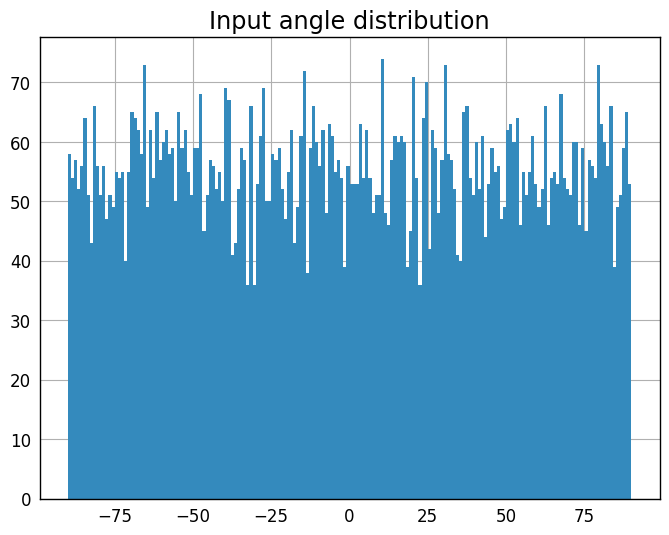

In [4]:
thist = plt.hist(angles,180,range=(-90,90))
plt.title("Input angle distribution")

# Angles recovered from this map

In [5]:
mask = source

# labelling
(labels, ntracks) = ndimage.measurements.label(mask, structure=(np.ones((3,3))))

# object extraction
evtlocs = ndimage.measurements.find_objects(labels)

tracks = []
for loc in evtlocs:
    tracks.append(mask[loc])

print(ntracks, "Events")

9896 Events


In [13]:
aold = []

bin_AC = 1/3
bin_AL = 1

for track in tracks:

    lac = 3*bin_AC*(track.shape[1]-1)
    lal = bin_AL*(track.shape[0]-1)
    if lac == 0:
        ang = 0
    elif lal == 0:
        ang = 90
    else:
        ang = np.arctan(3*bin_AC*track.shape[1]/(bin_AL*track.shape[0]))*180/np.pi

    aold.append(ang)

aold = np.array(aold)


anew = []

for track in tracks:
    ang,err = angle_linefit(track,pixratio=3*bin_AC/bin_AL)
    while ang>90:
        ang -= 180
    while ang<-90:
        ang += 180
    anew.append(ang)

anew = np.array(anew)

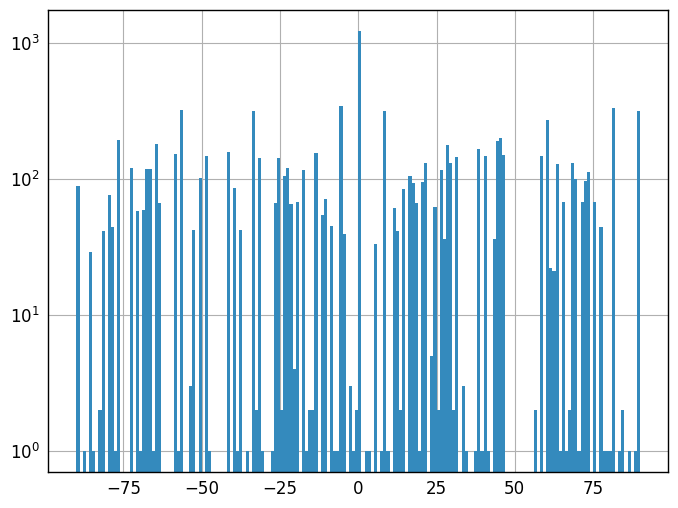

In [15]:
#thist = plt.hist(aold,180,range=(-90,90),log=True)
thist2 = plt.hist(anew,180,range=(-90,90),log=True)

-> Aside from binning, the same!

In [131]:
def bin_array_old(image, binx, biny):
    # rebin, using the maximum in each rectangle
    
    (xmax,ymax) = image.shape
    x_new = int(xmax/binx)
    y_new = int(ymax/biny)
    
    output = np.zeros((x_new,y_new,binx*biny))
    delx = np.arange(0,xmax,binx)
    dely = np.arange(0,ymax,biny)
    
    for ix in range(x_new):
        for iy in range(y_new):
            x0 = delx[ix]
            y0 = dely[iy]
            output[ix,iy,:] = image[x0:x0+binx,y0:y0+biny].flatten()
               
    return np.max(output,axis=2)

In [17]:
def bin_array(image, binx, biny):
    # rebin, using the maximum in each rectangle
    
    (xmax,ymax) = image.shape
    x_new = int(xmax/binx)
    y_new = int(ymax/biny)
    
    
    delx = np.arange(0,xmax,binx)
    dely = np.arange(0,ymax,biny)
    
    output = np.zeros((x_new,y_new))
    binned_x = np.zeros((x_new,ymax))
    
    # first the maxima along x
    for ix in range(x_new):
        x0 = delx[ix]
        binned_x[ix,:] = np.max(image[x0:x0+binx,:],axis=0)
    # then along y
    for iy in range(y_new):
        y0 = dely[iy]
        output[:,iy] = np.max(binned_x[:,y0:y0+biny],axis=1)
        
    return output

# Appearance in SM

In [18]:
binx = 2
biny = 6

source_sm = bin_array(source,binx,biny)
mask = source_sm

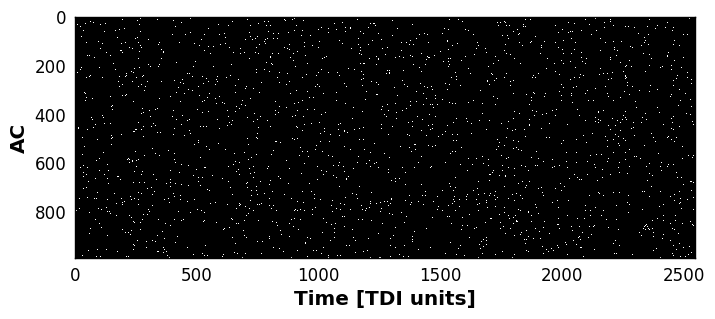

In [19]:
image=np.flip(np.rot90(source_sm,1),0) # this should follow the normal gaia convention
plt.xlabel('Time [TDI units]')
plt.ylabel('AC')
plt.imshow(image, cmap='gray')
plt.grid(False)

In [20]:
# labelling
(labels, ntracks) = ndimage.measurements.label(mask, structure=(np.ones((3,3))))

# object extraction
evtlocs = ndimage.measurements.find_objects(labels)

tracks = []
for loc in evtlocs:
    tracks.append(mask[loc])

print(ntracks, "Events")

9556 Events


In [21]:
aold = []

bin_AC = 2
bin_AL = 2

for track in tracks:

    lac = 3*bin_AC*(track.shape[1]-1)
    lal = bin_AL*(track.shape[0]-1)
    if lac == 0:
        ang = 0
    elif lal == 0:
        ang = 90
    else:
        ang = np.arctan(3*bin_AC*track.shape[1]/(bin_AL*track.shape[0]))*180/np.pi

    aold.append(ang)

aold = np.array(aold)


anew = []

for track in tracks:
    ang,err = angle_linefit(track,pixratio=3*bin_AC/bin_AL)
    while ang>90:
        ang -= 180
    while ang<-90:
        ang += 180
    anew.append(ang)

anew = np.array(anew)

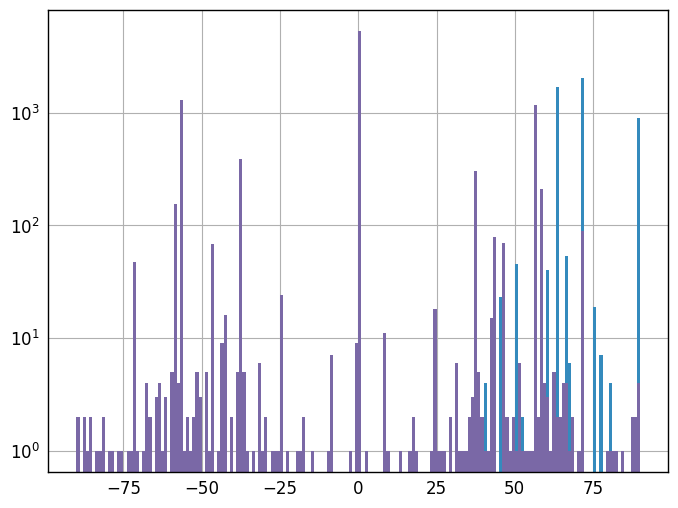

In [25]:
thist = plt.hist(aold,180,range=(-90,90),log=True)
thist2 = plt.hist(anew,180,range=(-90,90),log=True)

# Appearance in BAM

In [26]:
binx = 1
biny = 12

source_bam = bin_array(source,binx,biny)
mask = source_bam

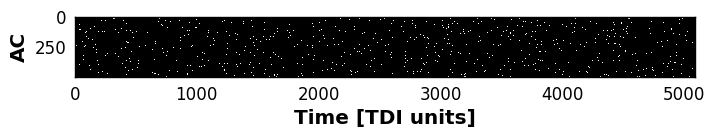

In [27]:
image=np.flip(np.rot90(source_bam,1),0) # this should follow the normal gaia convention
plt.xlabel('Time [TDI units]')
plt.ylabel('AC')
plt.imshow(image, cmap='gray')
plt.grid(False)

In [28]:
# labelling
(labels, ntracks) = ndimage.measurements.label(mask, structure=(np.ones((3,3))))

# object extraction
evtlocs = ndimage.measurements.find_objects(labels)

tracks = []
for loc in evtlocs:
    tracks.append(mask[loc])

print(ntracks, "Events")

9390 Events


In [29]:
aold = []

bin_AC = 2
bin_AL = 2

for track in tracks:

    lac = 3*bin_AC*(track.shape[1]-1)
    lal = bin_AL*(track.shape[0]-1)
    if lac == 0:
        ang = 0
    elif lal == 0:
        ang = 90
    else:
        ang = np.arctan(3*bin_AC*track.shape[1]/(bin_AL*track.shape[0]))*180/np.pi

    aold.append(ang)

aold = np.array(aold)


anew = []

for track in tracks:
    ang,err = angle_linefit(track,pixratio=3*bin_AC/bin_AL)
    while ang>90:
        ang -= 180
    while ang<-90:
        ang += 180
    anew.append(ang)

anew = np.array(anew)

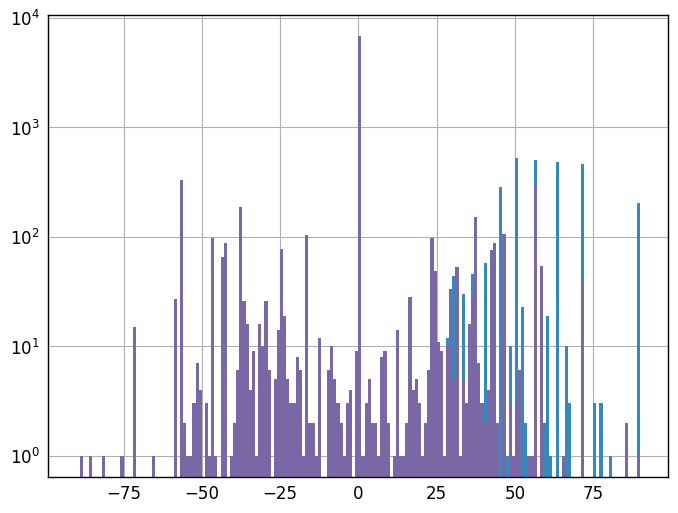

In [30]:
thist = plt.hist(aold,180,range=(-90,90),log=True)
thist2 = plt.hist(anew,180,range=(-90,90),log=True)

# Aside from some systematics in my rebinning and such, this matches very well!